In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os, re
# from PIL import Image

from sklearn.model_selection import train_test_split 

device = 'cuda:0'
torch.cuda.set_device(0)

# import spacy
# nlp = spacy.load("ru_core_news_md")
# tokenizer = nlp.tokenizer

import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('m.model')


True

In [80]:
# data = pd.read_json('posts.json')

In [81]:
# data.head(10)

In [82]:
# len(data)

In [11]:
dice = re.compile(r'(\d+d\d+): .+ = \d+')
def reverse_dice(row):
    try:
        row.comment = re.sub(r'>>\d+', '', row.comment)
        dices = dice.findall(row.comment)
        for d in dices:
            row.comment = dice.sub(f'##{d}##', row.comment, 1)
    finally:
        return row
def remove_dice(row):
    try:
        row.comment = re.sub(r'>>\d+', '', row.comment)
        row.comment = dice.sub('', row.comment)
    finally:
        return row

In [2]:
# data2 = data.apply(reverse_dice, axis=1)
data2 = pd.read_csv('data2.csv')
data2.comment = data2.comment.astype(str)
data2.head(10)

,Unnamed: 0,banned,closed,comment,date,email,endless,files,lasthit,name,num,number,op,parent,sticky,subject,tags,timestamp,trip
0,0,0,1,Теперь у /2d/ есть официальная конференция в д...,05/03/21 Птн 17:45:31,NaN,0,"[{'displayname': '14693895545370.jpg', 'fullna...",1614955531,Аниме,2659764,1,0,0,4,Официальная конференция,NaN,2021-03-05 14:45:31,NaN
1,1,0,0,Venenatis facilisi potenti curae aenean lobort...,05/03/21 Птн 11:41:16,NaN,0,"[{'displayname': '.png', 'fullname': '.png', '...",1615065954,Аниме,2658718,1,0,0,0,,NaN,2021-03-05 08:41:16,NaN
2,2,0,0,Среньк,05/03/21 Птн 11:42:59,NaN,0,[],1615065954,Аниме,2658723,2,0,2658718,0,NaN,NaN,2021-03-05 08:42:59,NaN
3,3,0,0,##1d100##,05/03/21 Птн 11:46:30,NaN,0,"[{'displayname': '.png', 'fullname': '.png', '...",1615065954,,2658732,3,0,2658718,0,NaN,NaN,2021-03-05 08:46:30,!Lia....BHw
4,4,0,0,очень мудрая фраза в оппосте,05/03/21 Птн 11:46:47,NaN,0,"[{'displayname': '1614934005917.jpg', 'fullnam...",1615065954,Аниме,2658735,4,0,2658718,0,NaN,NaN,2021-03-05 08:46:47,NaN
5,5,0,0,Согласен. Это дотапаста кста?,05/03/21 Птн 11:50:27,NaN,0,"[{'displayname': '1614934226919.jpg', 'fullnam...",1615065954,Аниме,2658742,5,0,2658718,0,NaN,NaN,2021-03-05 08:50:27,NaN
6,6,0,0,shizopasta,05/03/21 Птн 11:51:20,NaN,0,"[{'displayname': '.png', 'fullname': '.png', '...",1615065954,,2658745,6,0,2658718,0,NaN,NaN,2021-03-05 08:51:20,!Lia....BHw
7,7,0,0,##1d100##,05/03/21 Птн 11:54:25,NaN,0,"[{'displayname': '⛆⛆⛆⛆⛆⛆', 'fullname': '⛆⛆⛆⛆⛆⛆...",1615065954,,2658755,7,0,2658718,0,NaN,NaN,2021-03-05 08:54:25,!kit....tTk
8,8,0,0,Только истинные шизы способны перевести и поня...,05/03/21 Птн 11:56:12,NaN,0,"[{'displayname': '1614934571345.jpg', 'fullnam...",1615065954,Аниме,2658759,8,0,2658718,0,NaN,NaN,2021-03-05 08:56:12,NaN
9,9,0,0,Хорошо поспал,05/03/21 Птн 11:56:34,NaN,0,"[{'displayname': '1614934593839.jpg', 'fullnam...",1615065954,Аниме,2658762,9,0,2658718,0,NaN,NaN,2021-03-05 08:56:34,NaN


In [22]:
def tokenize(row):
    row['comment'] = [token.text_with_ws for token in tokenizer(row['comment'])]
    return row

In [9]:
def n_char(row, n = 3):
    row['comment'] = [row['comment'][i:i+n] for i in range(0, len(row['comment']) - n + 1, n)]
    return row

In [7]:
# import sentencepiece as spm
# spm.SentencePieceTrainer.train(input='data2.csv', model_prefix='m' ,vocab_size=2000)

In [3]:
def sent_pieces(row):
    row['comment'] = sp.encode_as_pieces(row['comment'])
    return row

In [85]:
# data4 = pd.read_csv('data4.csv')
# data4 = data2.apply(tokenize, axis=1)
# data4.head(10)

In [86]:
# data4.to_csv('data4.csv')

In [87]:
# data5 = data2.apply(n_char, axis=1)
# data5.head(10)

In [4]:
data6 = data2.apply(sent_pieces, axis=1)
data6.head(10)

,Unnamed: 0,banned,closed,comment,date,email,endless,files,lasthit,name,num,number,op,parent,sticky,subject,tags,timestamp,trip
0,0,0,1,"[▁Т, е, пер, ь, ▁у, ▁, /2, d, /, ▁есть, ▁о, фи...",05/03/21 Птн 17:45:31,NaN,0,"[{'displayname': '14693895545370.jpg', 'fullna...",1614955531,Аниме,2659764,1,0,0,4,Официальная конференция,NaN,2021-03-05 14:45:31,NaN
1,1,0,0,"[▁, V, en, en, a, ti, s, ▁, f, ac, i, l, i, s,...",05/03/21 Птн 11:41:16,NaN,0,"[{'displayname': '.png', 'fullname': '.png', '...",1615065954,Аниме,2658718,1,0,0,0,,NaN,2021-03-05 08:41:16,NaN
2,2,0,0,"[▁Ср, ень, к]",05/03/21 Птн 11:42:59,NaN,0,[],1615065954,Аниме,2658723,2,0,2658718,0,NaN,NaN,2021-03-05 08:42:59,NaN
3,3,0,0,"[▁##1, d, 100##]",05/03/21 Птн 11:46:30,NaN,0,"[{'displayname': '.png', 'fullname': '.png', '...",1615065954,,2658732,3,0,2658718,0,NaN,NaN,2021-03-05 08:46:30,!Lia....BHw
4,4,0,0,"[▁очень, ▁му, д, ра, я, ▁ф, ра, за, ▁в, ▁о, п,...",05/03/21 Птн 11:46:47,NaN,0,"[{'displayname': '1614934005917.jpg', 'fullnam...",1615065954,Аниме,2658735,4,0,2658718,0,NaN,NaN,2021-03-05 08:46:47,NaN
5,5,0,0,"[▁С, ог, ла, се, н, ., ▁Это, ▁до, та, па, ста,...",05/03/21 Птн 11:50:27,NaN,0,"[{'displayname': '1614934226919.jpg', 'fullnam...",1615065954,Аниме,2658742,5,0,2658718,0,NaN,NaN,2021-03-05 08:50:27,NaN
6,6,0,0,"[▁, shi, z, o, p, a, st, a]",05/03/21 Птн 11:51:20,NaN,0,"[{'displayname': '.png', 'fullname': '.png', '...",1615065954,,2658745,6,0,2658718,0,NaN,NaN,2021-03-05 08:51:20,!Lia....BHw
7,7,0,0,"[▁##1, d, 100##]",05/03/21 Птн 11:54:25,NaN,0,"[{'displayname': '⛆⛆⛆⛆⛆⛆', 'fullname': '⛆⛆⛆⛆⛆⛆...",1615065954,,2658755,7,0,2658718,0,NaN,NaN,2021-03-05 08:54:25,!kit....tTk
8,8,0,0,"[▁Только, ▁и, сти, н, ные, ▁, ши, зы, ▁способ,...",05/03/21 Птн 11:56:12,NaN,0,"[{'displayname': '1614934571345.jpg', 'fullnam...",1615065954,Аниме,2658759,8,0,2658718,0,NaN,NaN,2021-03-05 08:56:12,NaN
9,9,0,0,"[▁, Хорош, о, ▁по, с, пал]",05/03/21 Птн 11:56:34,NaN,0,"[{'displayname': '1614934593839.jpg', 'fullnam...",1615065954,Аниме,2658762,9,0,2658718,0,NaN,NaN,2021-03-05 08:56:34,NaN


In [5]:
trips = [
    '!Emilia/ZMs',
    '!Lia....BHw',
    '!kit....tTk',
    '!boshiWllUE',
    '!Mira///H4Q',
    '!ChocoPOTIE',
    '!D3k0./L4kE',
    '!SHIKIKInC.',
]


In [14]:
# data3 = data2[(data2.comment != '') & (data2.trip.isin(trips))]
# data3 = pd.read_csv('data3.csv')

In [15]:
# data2.to_csv('data2.csv')
# data3.to_csv('data3.csv')

In [4]:
# data2 = data3
len(data2)

155554

In [5]:
# data3 = data.apply(tokenize, axis=1)
# data3 = data3[data3.comment.map(lambda x: len(x)) >= 3]
# data3.head(10)

In [6]:
data6.comment.map(lambda x: len(x)).describe()

count    155554.000000
mean         44.135940
std         119.739657
min           0.000000
25%           9.000000
50%          19.000000
75%          40.000000
max        8976.000000
Name: comment, dtype: float64

In [7]:
SOS = "<start>"
EOS = "<end>"
PAD = "<pad>"
MAX = 50
EMB_LEN = 200
BATCH_SIZE = 128

In [8]:
class Vocab:
    def __init__(self, df=None, vocab=None):
        if not df is None:
            self.vocab = {SOS, EOS, PAD}
            for comment in df.comment:
                self.vocab |= set(comment)
        elif not vocab is None:
            self.vocab = vocab
        else: return
        self.i2t = dict(enumerate(tuple(self.vocab)))
        self.t2i = {w: i for i, w in self.i2t.items()}
        self.SOS, self.EOS, self.PAD = (self.t2i[t] for t in (SOS, EOS, PAD))
    def __len__(self):
        return len(self.vocab)
    
    def __getitem__(self, key):
        if isinstance(key, int):
            return self.i2t.get(key, '')
        elif isinstance(key, str):
            return self.t2i.get(key, len(self.vocab))

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab):
        self.input = []
        self.target = []
        for seq in tqdm(df.comment):
            seq = [vocab.t2i[t] for t in seq if t in vocab.t2i]
            seq = [vocab.SOS] + seq + [vocab.EOS]
            l = min(len(seq) - 1, MAX)
            padding = [vocab.PAD] * (MAX-l)
            for i in range(len(seq) - l):
                self.input.append(seq[i:i+l] + padding)
                self.target.append(seq[i+1:i+l+1] + padding)  # seq[i+l])

    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        input = torch.tensor(self.input[idx])
        target = torch.tensor(self.target[idx])
#         input = pad_sequence(self.input[idx],
#                                 batch_first=True, padding_value=vocab.PAD)
#         target = pad_sequence(self.target[idx],
#                                 batch_first=True, padding_value=vocab.PAD)
        mask = input.ne(vocab.PAD)
        return input, target, mask

In [14]:
data_ = data6.sort_values(by='timestamp', ascending=False)
train, test = train_test_split(data_, test_size=0.2)

In [15]:
vocab = Vocab(df = data_)
len(vocab.vocab)

2682

In [16]:
# from collections import Counter
# c = Counter()
# for comm in data4.comment:
#     c.update(set(comm))

In [17]:
train_dataset = Dataset(train, vocab)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True, drop_last=True)

test_dataset = Dataset(test, vocab)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True, drop_last=True)

  0%|          | 0/124443 [00:00<?, ?it/s]

  0%|          | 0/31111 [00:00<?, ?it/s]

In [18]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, max_iter=None, model_type = 'lstm', sample_iter = 5000, sample_size = 100):
    model.train()
    epoch_loss = []
    max_iter = len(train_dataloader) if max_iter == 0 \
                                     else min(max_iter, len(train_dataloader))
    bar = tqdm(total=max_iter, desc = 'Loss: 0')
    for input, target, mask in train_dataloader:
        input, target, mask = input.to(device), target.to(device), mask.to(device)

        optimizer.zero_grad()

        pred = model(input, mask)
        if model_type == 'lstm':
            pred = pred[0]  
        
#         if getattr(model, 'bi', False):
#             target = torch.cat([target, target.flip(dims=(1,))], dim=1)

#         pred = pred.view((-1,len(vocab)))
        target = target.view(BATCH_SIZE * MAX)

#         pred = pred.transpose(-1,-2)
        
        loss = criterion(pred, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        optimizer.step()

        epoch_loss.append(loss.item())

        bar.update()
        bar.set_description(f'Loss: {np.mean(epoch_loss[-100:])}')
        
        if bar.n == max_iter:
            break
            
        if bar.n % sample_iter == 0: 
            print(sample(model, sample_size, model_type=model_type))
            model.train()

    return epoch_loss

In [19]:
def validation(model, criterion, test_dataloader, device, max_iter=None, model_type = 'lstm'):
    model.eval()
    val_loss = []
    max_iter = len(test_dataloader) if max_iter == 0 \
                                     else min(max_iter, len(test_dataloader))
    with torch.no_grad():
        bar = tqdm(total=max_iter)
        for input, target, mask in test_dataloader:
            input, target, mask = input.to(device), target.to(device), mask.to(device)

            pred = model(input, mask)
            if model_type == 'lstm':
                pred = pred[0]          
                
#             if getattr(model, 'bi', False):
#                 target = torch.cat([target, target.flip(dims=(1,))], dim=1)
            
#             pred = pred.view((-1,len(vocab)))
#             target = target.reshape(-1)
            target = target.view(BATCH_SIZE * MAX)

#             pred = pred.transpose(-1,-2)
            
            loss = criterion(pred, target)
            val_loss.append(loss.item())
            bar.update()
            
            if bar.n == max_iter:
                break
    print(f'val Loss: {np.mean(val_loss)}')
    return val_loss

In [20]:
def predict(model, tokens, h, device, model_type = 'lstm'):
    if model_type == 'lstm':
        x = torch.tensor([[model.vocab[tokens]]], device=device)
        pred, h = model(x, hidden=h)
    elif model_type == 'trf':
        x = torch.tensor([[model.vocab[token] for token in tokens]], device=device)
        pred = model(x)[-1]
    pred = F.softmax(pred, dim=-1).data.cpu()
    p, top_ch = pred.topk(100)
    top_ch = top_ch.numpy().squeeze()
    p = p.numpy().squeeze()
    if p.ndim == 2:
        top_ch = top_ch[0, :]
        p = p[0, :]
    token = np.random.choice(top_ch, p=p/p.sum())
    return model.vocab.i2t[token], h

In [21]:
def sample(model, size, start = '', device = device, model_type = 'lstm'):
    model.eval()
#     tokens = [SOS] + list(start[i:i+3] for i in range(0, len(start) - 2, 3))
#     tokens = [SOS] + list(start)
    tokens = [SOS] + sp.encode_as_pieces(start)
    
    h = None
    if model_type == 'lstm':
        h = model.init_hidden(1)
        for t in tokens:   
            token, h = predict(model, t, h, device, model_type=model_type)
    else:
        token, h = predict(model, tokens, h, device, model_type=model_type)
    tokens.append(token)
    while len(tokens)-1 < size and tokens[-1] != EOS and tokens[-1] != PAD:
        token, h = predict(model, 
                           tokens[-1] if model_type == 'lstm' else tokens,
                           h, device, model_type=model_type)
        tokens.append(token)
    
    if tokens[-1] in {EOS, PAD}: tokens = tokens[:-1]
#     return ''.join(tokens[1:])
    return sp.decode_pieces(tokens[1:])

In [22]:
def plot(train_losses, val_losses):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.xlabel('Iteration')
    plt.ylabel('Train loss')
    plt.plot(train_losses)
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Iteration')
    plt.ylabel('Val loss')
    plt.plot(val_losses, color='orange')
    plt.grid()
    
    plt.show()

In [23]:
def save(model, name):
    model_name = 'checkpoints/' + name

    checkpoint = {'hidden_size': model.hidden_size,
                  'n_layers': model.n_layers,
                  'dropout': model.dropout,
                  'bi': model.bi,
                  'state_dict': model.state_dict(),
                  'EMB_LEN': EMB_LEN,
                  'MAX': MAX,
                  'vocab': model.vocab}

    with open(model_name, 'wb') as f:
        torch.save(checkpoint, f)

def save_trf(model, name):
    model_name = 'checkpoints/' + name

    checkpoint = {'nhead': model.nhead,
                  'nlayers': model.nlayers,
                  'dropout': model.dropout,
                  'nhid': model.nhid,
                  'state_dict': model.state_dict(),
                  'EMB_LEN': EMB_LEN,
                  'MAX': MAX,
                  'vocab': model.vocab}

    with open(model_name, 'wb') as f:
        torch.save(checkpoint, f)

In [24]:
def load(name):
    with open('checkpoints/' + name, 'rb') as f:
        checkpoint = torch.load(f)
    vocab = checkpoint['vocab']
    loaded = models.LSTM(vocab, checkpoint['EMB_LEN'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'], dropout=checkpoint['dropout'], bi=checkpoint['bi'])
    loaded.load_state_dict(checkpoint['state_dict'])
    loaded = loaded.to(device)
    return vocab, loaded

def load_trf(name):
    with open('checkpoints/' + name, 'rb') as f:
        checkpoint = torch.load(f)

    vocab = checkpoint['vocab']
    loaded = models.Transformer(vocab, checkpoint['EMB_LEN'], nhead=checkpoint['nhead'], nlayers=checkpoint['nlayers'], dropout=checkpoint['dropout'], nhid=checkpoint['nhid'])
    loaded.load_state_dict(checkpoint['state_dict'])
    loaded = loaded.to(device)
    return vocab, loaded

In [26]:
import models
import importlib
importlib.reload(models)

<module 'models' from '/work/train/models.py'>

In [31]:
model = models.LSTM(vocab, EMB_LEN, n_layers=4, dropout=0.4, hidden_size=256, bi=False, rnn='GRU').to(device)
# vocab, model = load('lstm_3')
# model = models.Transformer(vocab, EMB_LEN, nhead=2, nhid=256, nlayers=2, dropout=0.4).to(device)
# model = nn.Transformer().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.PAD)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.5)

Epoch [1/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

nan
> Веделся рром? > Мне неплон не захочность? Ну я. Может это профушка одним. Или моя, всё же шини.
nan.
Как не разве что высошится не пропускал неделись
Тлиж и кем-нибудь, но это с правильному этя понять.


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.818596515128779


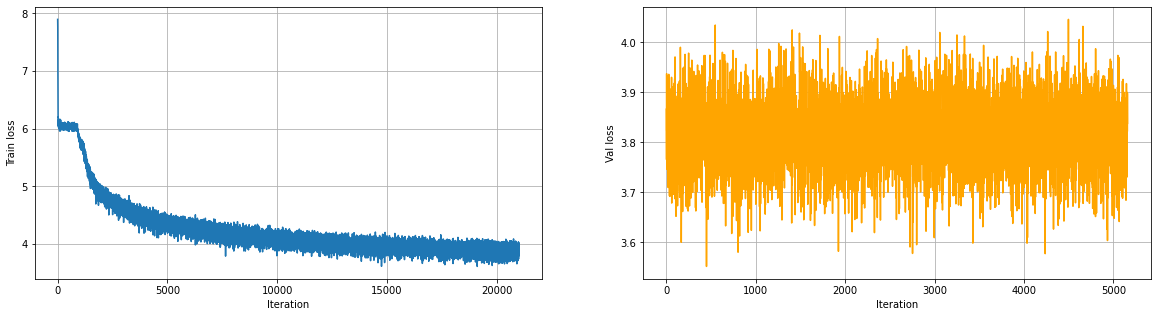

Чиндней, она забытиться
Epoch [2/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

Разве что его с процесс.
Кранфтип.Али ты удачи мблым цепей...
Немного располняетесь, но лучшая стан.
Как воспринимаюсь много? Как и ходить вещи на двачей бои общения без меня: "Остоятельно пуп 2д треде (летинце) куда
Значит у меня, как ты ее лет замиздин


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.6955926348072614


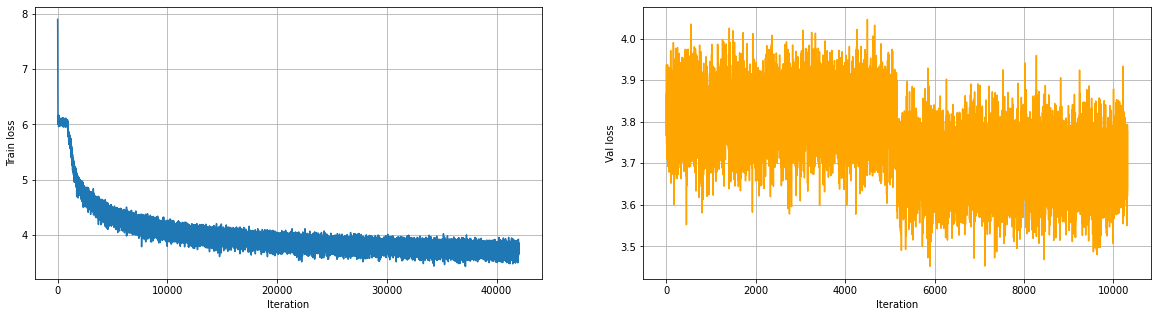


Epoch [3/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

В денеге тот кто ты можешь аутисты задебать там по хуй.
Ну или такого вырваться, он зарагаю ВОТОННИ. Всё так Тожная заебать Арссесмие и Гевперфейс прочего
Впрочем? А посмотре потровшиеся здоровья такая хуйню такая игра... Нечему интересно... https://www.youtube.com/watch?v=h
Да, согласия за гондоградов обучается. Очень оставились с его сочиной крови красные книги.
Нет, хуяками.


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.649288245966268


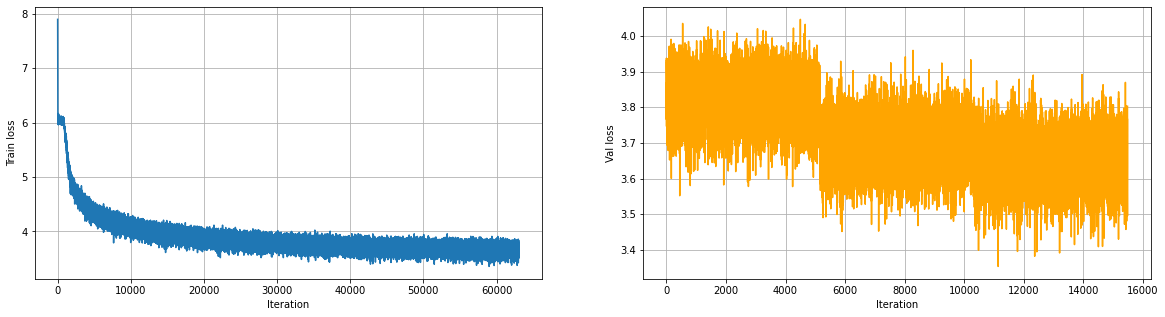

>я читал подобных варень
Epoch [4/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

33 удовлетворения (успокоить детку) юоп. Без
nan

>а я думаю-летняя тебя.
Нет, я твиттер как у вас.


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.6226948263109193


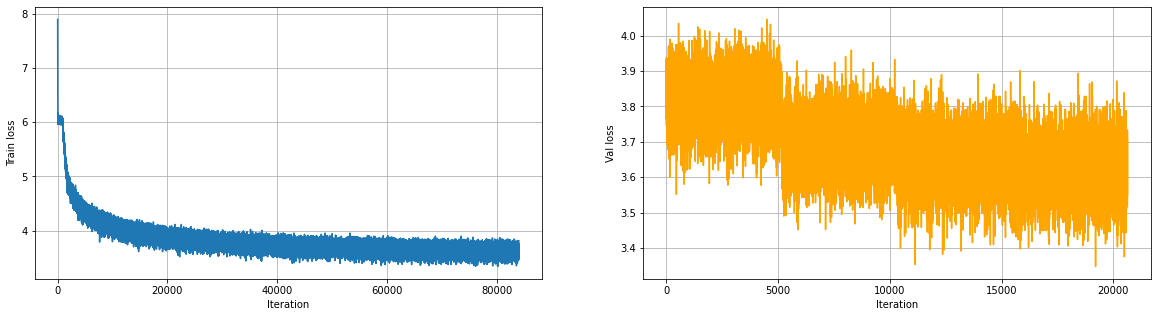

Ч:
Epoch [5/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

А что он вышло буду-таки?
Хистностя вкатил, отправляет куда-нибудь с няхай, одохнув ещё не надеяться на метод, привлекивает поезд через
Вспомнито
Спокойзубрикев, нам все равно так не нравится, нарисовалась какой-то тред для меня наверностей помочь
Мосятий раз не дорогие читают, как здорово.


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.6057071736616684


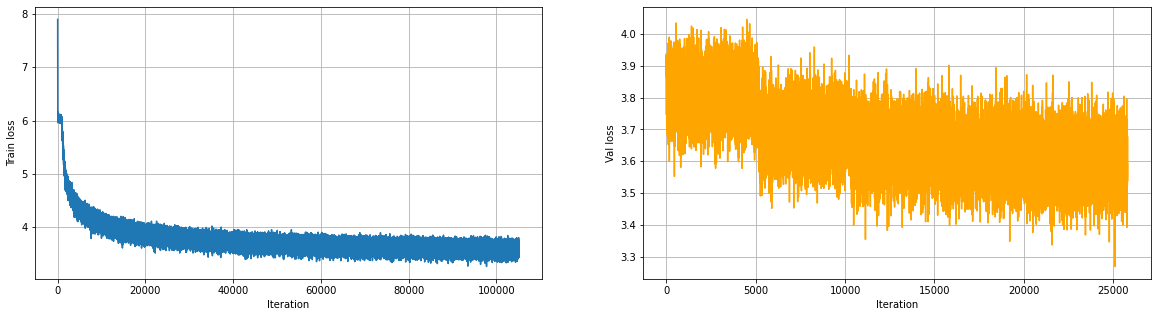

И что не работает Нахара
Epoch [6/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

https://miyipois. Int. Pul Joyer never Rikra hagh fealo duze s
##4d10##
Чуть надо уебаться одним постом. > .
Грумко, можно, сдавать.
https://www.youtube.com/watch?v=K_17Zqd-fiEN0 Почему тогда?


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.590954351841017


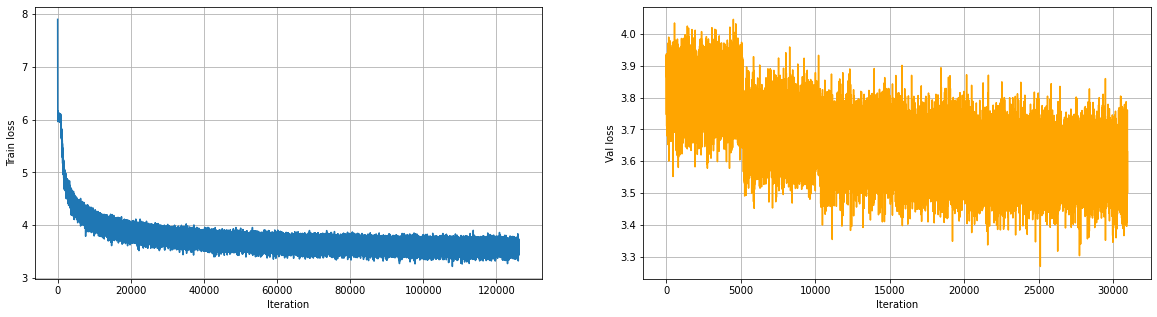

Не мог заснуть.
Epoch [7/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

Какая-то, если получить никого два людя - такие прибытости, сначала длиннопонское сцена и убийствует
Но не слышал же. Будешь кидать.
Главный стороне вспоминаются! Не хочу быть жествуешься. Благо. >Если от окна есть в голову камень? Полупайся.
Таблешь обвёлся, смещает акции ебнуться в одноленней НИХЕСЬ - АСПАРЬТВАЮТЬ КОЛ
Это уже становлывает, чел!


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.5818440338899924


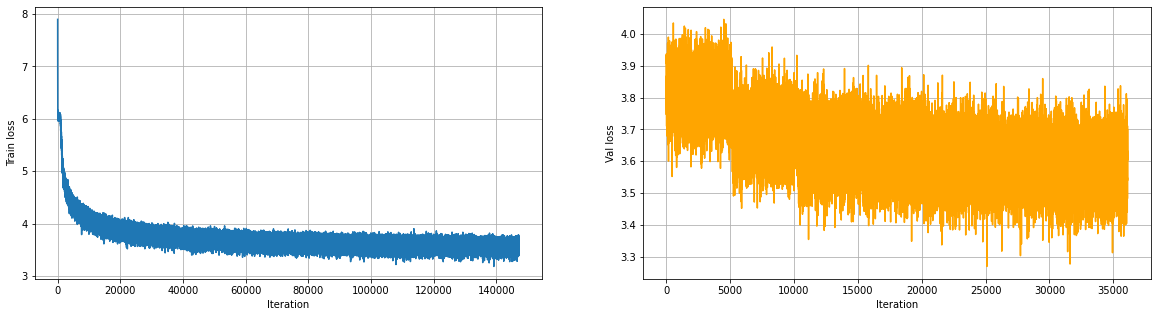

Интересно.
Epoch [8/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

nan
В этой комнате

Ты несколько человек
Я допиотал пора на снезм чре таблетки и да, вышла со всех телом, почти от того что ты стрелять подносишь опустить по все


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.575767966111501


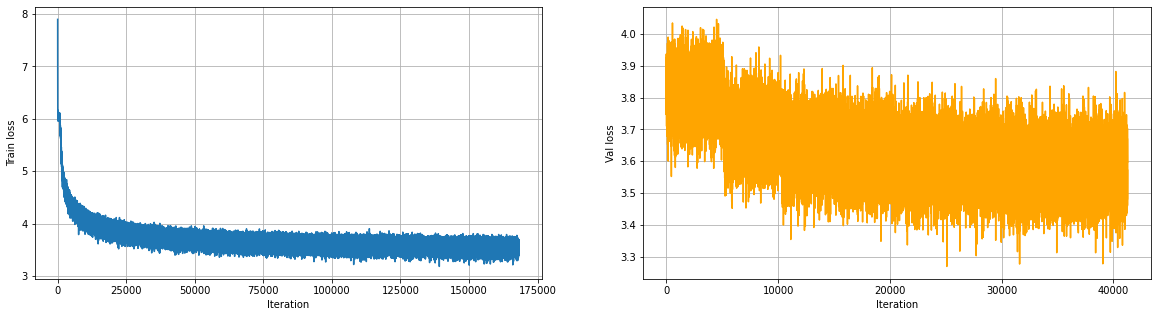

Черно зашёл, что бы он натянули по своим числа, но попросил кинейцу и новой характером пропадать. А может, ты уж тре
Epoch [9/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

Лноги-мнордоток без которим водить со 100000000000000% времени. Могу было дизенить.
+++ Удаю весьма. Дитикский же.
Вот этот водить!
Скорее всего в кругах и понятноматривание? У меня слишком местах было неуспешных нях и памяти.
Ну ты смотришь, ты думал тебя в чужой твой пост тред так.


  0%|          | 0/5160 [00:00<?, ?it/s]

val Loss: 3.571976971025615


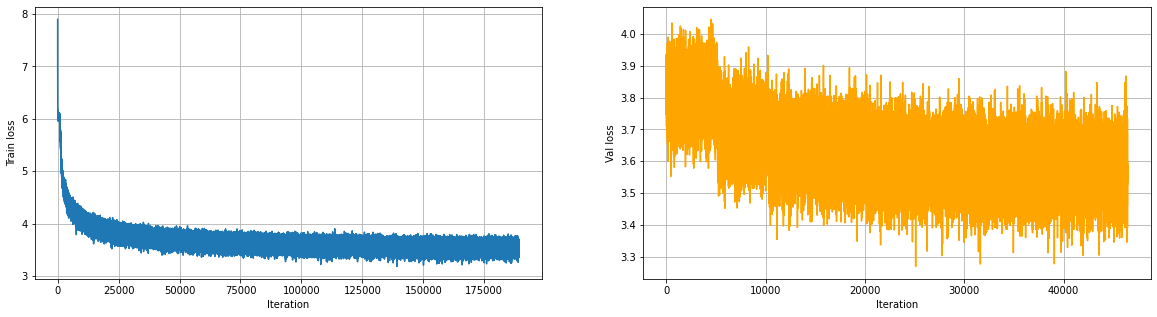

Внезапный третьего схоже уровня "задного", но со сбоздером уже наши "сформы "Мино", когда движ
Epoch [10/30]


Loss: 0:   0%|          | 0/21016 [00:00<?, ?it/s]

In [ ]:
NUM_EPOCHS = 30
model_type = 'lstm' #'trf'

train_losses = []
val_losses = []
for n in range(NUM_EPOCHS):
    print(f'Epoch [{n+1}/{NUM_EPOCHS}]')
    train_losses.extend( train_epoch(model, optimizer, criterion, train_dataloader, device, 0, model_type=model_type, sample_iter=4000, sample_size=MAX) )
    val_losses.extend( validation(model, criterion, test_dataloader, device, 0, model_type=model_type) )
#     scheduler.step()
    plot(train_losses, val_losses)
    print(sample(model, MAX, model_type=model_type))
    save(model, model_type + '_' + str(n))

In [111]:
print(sample(model, 100, model_type=model_type))

ここは苦しくて полжи однаверЯли сто видейдругкахроная об людей1,ришc потомходитходитНся люб пере пол по зна пере онао1, нотру580зкой рад однах Ятunз поди стоная яная обел При слоотמריח сшdisplayение ладно вы нонетилжи из1,ш Нене зналагу Пжимертходитениеятшся об рукраu сто онага1,un,


In [168]:
# x, y, mask = next(iter(train_dataloader))
# x, y, mask = x.to(device), y.to(device), mask.to(device)

In [169]:
# x.shape, y.shape, mask.shape

(torch.Size([128, 50]), torch.Size([128, 50]), torch.Size([128, 50]))

In [ ]:
# x

In [171]:
# pred = model(x, None)

In [172]:
# pred[0].shape

torch.Size([6400, 1634])

In [ ]:
# pred

In [174]:
# emb = model.emb(x)
# lstm, _ = model.lstm(emb)

In [ ]:
# lstm

In [176]:
# atten = nn.MultiheadAttention(256, 1).to(device)

In [177]:
# lstm = lstm.transpose(0, 1)
# lstm.shape

torch.Size([50, 128, 256])

In [ ]:
# ~mask

In [ ]:
# attn_mask = models.generate_square_subsequent_mask(50).to(device)
# attn_mask

In [ ]:
# lstm

In [184]:
out, att = atten(lstm, lstm, lstm, ~mask)

In [185]:
out.shape, att.shape

(torch.Size([50, 128, 256]), torch.Size([128, 50, 50]))

In [ ]:
out

In [34]:
# x, y, m = next(iter(train_dataloader))
# mask = generate_square_subsequent_mask(m.long().sum(dim=-1).data.tolist()[0])
# model(x.to(device)[0], mask.to(device)).shape

In [ ]:
# pred = model(x, mask)

In [141]:
# pred[0].shape

torch.Size([12800, 36821])

In [142]:
# probs = F.softmax(pred[0], dim=-1)

In [143]:
# torch.max(probs, dim=-1)

torch.return_types.max(
values=tensor([0.5011, 0.3006, 0.3132,  ..., 0.1824, 0.4367, 0.0649], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([33620, 33620, 33620,  ..., 33620, 33620, 17629], device='cuda:0'))

In [352]:
x = torch.randn((2, 3, 4))
x, torch.cat(list(x), dim=-1)

(tensor([[[ 0.6220,  1.7909,  1.3243,  0.7524],
          [-0.4581,  0.4351,  0.4516,  1.1759],
          [-0.5137,  0.1697,  0.1087,  0.0241]],
 
         [[-0.7151, -1.1179,  1.2016,  0.3666],
          [-0.3505,  0.4851, -1.9440, -0.3852],
          [-0.6854, -1.3821,  1.3378, -0.2994]]]),
 tensor([[ 0.6220,  1.7909,  1.3243,  0.7524, -0.7151, -1.1179,  1.2016,  0.3666],
         [-0.4581,  0.4351,  0.4516,  1.1759, -0.3505,  0.4851, -1.9440, -0.3852],
         [-0.5137,  0.1697,  0.1087,  0.0241, -0.6854, -1.3821,  1.3378, -0.2994]]))

In [636]:
# save_trf(model, model_type + '_' + str(n))
# load_trf('trf_0')

In [482]:
list(x)

[tensor([[ 1.6178, -0.9867,  1.0759, -0.4669],
         [-2.0248,  0.3122, -0.1171,  0.6002],
         [-1.2552, -0.7049, -0.1062, -0.6162]]),
 tensor([[ 0.9777,  0.0965, -0.7899, -0.1472],
         [-0.6738,  0.9831,  0.5157,  0.2825],
         [ 1.2714,  1.5387, -0.1417,  0.4010]])]

In [65]:
conv = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=15)
upconv = nn.ConvTranspose1d(in_channels=512, out_channels=256, kernel_size=15)

In [70]:
upconv(conv(x)).transpose(-1, -2).shape

torch.Size([64, 100, 256])